In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import collections

from construct import *

from gnuradio.digital import crc

import sys
sys.path.append('../Tianwen')

import ccsds

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
TMPrimaryHeader = BitStruct(
    'transfer_frame_version_number' / BitsInteger(2),
    'spacecraft_id' / BitsInteger(10),
    'virtual_channel_id' / BitsInteger(3),
    'ocf_flag' / Flag,
    'master_channel_frame_count' / BitsInteger(8),
    'virtual_channel_frame_count' / BitsInteger(8),
    'secondary_header_flag' / Flag,
    'synch_flag' / Flag,
    'packet_order_flag' / Flag,
    'segment_length_id' / BitsInteger(2),
    'first_header_pointer' / BitsInteger(11)
)

In [3]:
frame_size = 4 * 223
frames = np.fromfile('bgm1_dwingeloo_frames.u8', dtype='uint8')
frames = frames[:frames.size//frame_size*frame_size].reshape(-1, frame_size)
frames.shape

(1041, 892)

In [4]:
rs_inter = 4
frames_deinter = np.einsum('ijk->ikj', frames.reshape(-1, frames.shape[1]//rs_inter, rs_inter)).reshape(frames.shape)

In [5]:
crc16 = crc(16, 0x1021, 0xffff, 0x0, False, False)
crc_ok = np.array([crc16.compute(frame) == 0 for frame in frames_deinter])
np.average(crc_ok == False)

np.float64(0.0038424591738712775)

In [6]:
frames_ok = frames_deinter[crc_ok]

In [7]:
tm_headers = [TMPrimaryHeader.parse(a) for a in frames_ok]
scid = np.array([h.spacecraft_id for h in tm_headers])
vcid = np.array([h.virtual_channel_id for h in tm_headers])
mcfc = np.array([h.master_channel_frame_count for h in tm_headers])
vcfc = np.array([h.virtual_channel_frame_count for h in tm_headers])
tm_headers[:10]

[Container(transfer_frame_version_number=0, spacecraft_id=4, virtual_channel_id=2, ocf_flag=False, master_channel_frame_count=163, virtual_channel_frame_count=163, secondary_header_flag=False, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=0),
 Container(transfer_frame_version_number=0, spacecraft_id=4, virtual_channel_id=2, ocf_flag=False, master_channel_frame_count=164, virtual_channel_frame_count=164, secondary_header_flag=False, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=0),
 Container(transfer_frame_version_number=0, spacecraft_id=4, virtual_channel_id=2, ocf_flag=False, master_channel_frame_count=165, virtual_channel_frame_count=165, secondary_header_flag=False, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=0),
 Container(transfer_frame_version_number=0, spacecraft_id=4, virtual_channel_id=2, ocf_flag=False, master_channel_frame_count=166, virtual_channel_frame_c

In [8]:
collections.Counter(scid)

Counter({np.int64(4): 1037})

In [9]:
collections.Counter(vcid)

Counter({np.int64(2): 1009, np.int64(7): 28})

In [10]:
[h for h in tm_headers if h.virtual_channel_id == 7][:10]

[Container(transfer_frame_version_number=0, spacecraft_id=4, virtual_channel_id=7, ocf_flag=False, master_channel_frame_count=2, virtual_channel_frame_count=2, secondary_header_flag=False, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=0),
 Container(transfer_frame_version_number=0, spacecraft_id=4, virtual_channel_id=7, ocf_flag=False, master_channel_frame_count=2, virtual_channel_frame_count=2, secondary_header_flag=False, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=0),
 Container(transfer_frame_version_number=0, spacecraft_id=4, virtual_channel_id=7, ocf_flag=False, master_channel_frame_count=2, virtual_channel_frame_count=2, secondary_header_flag=False, synch_flag=False, packet_order_flag=False, segment_length_id=3, first_header_pointer=0),
 Container(transfer_frame_version_number=0, spacecraft_id=4, virtual_channel_id=7, ocf_flag=False, master_channel_frame_count=2, virtual_channel_frame_count=2, second

In [11]:
np.all(mcfc == vcfc)

np.True_

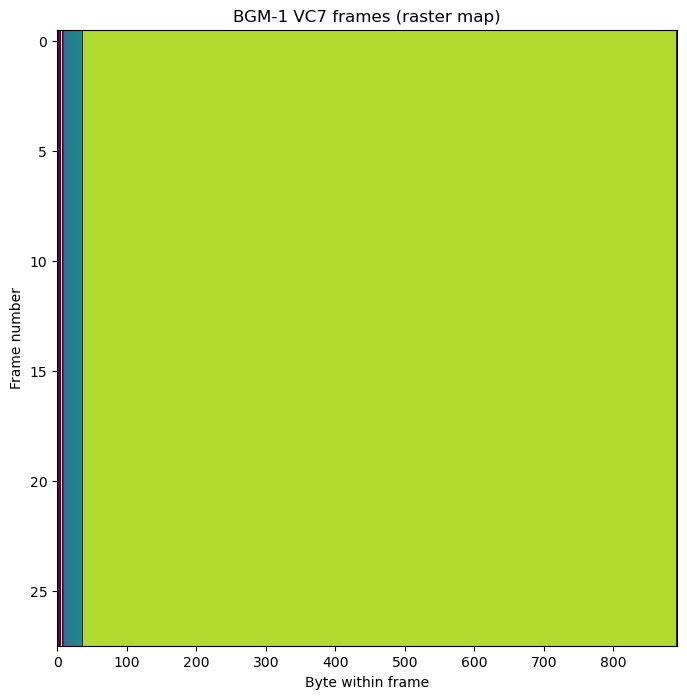

In [12]:
plt.figure(figsize=(8, 8))
plt.imshow(frames_ok[vcid == 7], interpolation='none', aspect='auto')
plt.title('BGM-1 VC7 frames (raster map)')
plt.xlabel('Byte within frame')
plt.ylabel('Frame number');

In [13]:
np.all(frames_ok[vcid == 7] == frames_ok[vcid == 7][0])

np.True_

In [14]:
bytes(frames_ok[vcid == 7][0][6:10]).hex()

'fe00001f'

In [15]:
bytes(frames_ok[vcid == 7][0][10:36])

b'abcdefghijklmnopqrstuvwxyz'

In [16]:
bytes(frames_ok[vcid == 7][0][36:37]).hex()

'0a'

In [17]:
np.all(frames_ok[vcid == 7][0][37:-2] == 0xe0)

np.True_

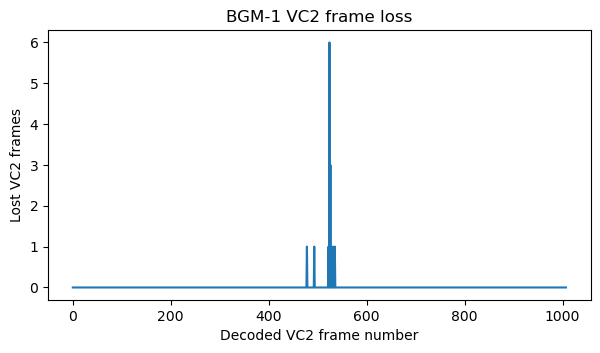

In [18]:
vcfc_unwrap = np.int32(np.round(np.unwrap(vcfc[vcid == 2] / 256 * 2 * np.pi) / (2 * np.pi) * 256))
plt.plot(np.diff(vcfc_unwrap) - 1)
plt.title('BGM-1 VC2 frame loss')
plt.xlabel('Decoded VC2 frame number')
plt.ylabel('Lost VC2 frames');

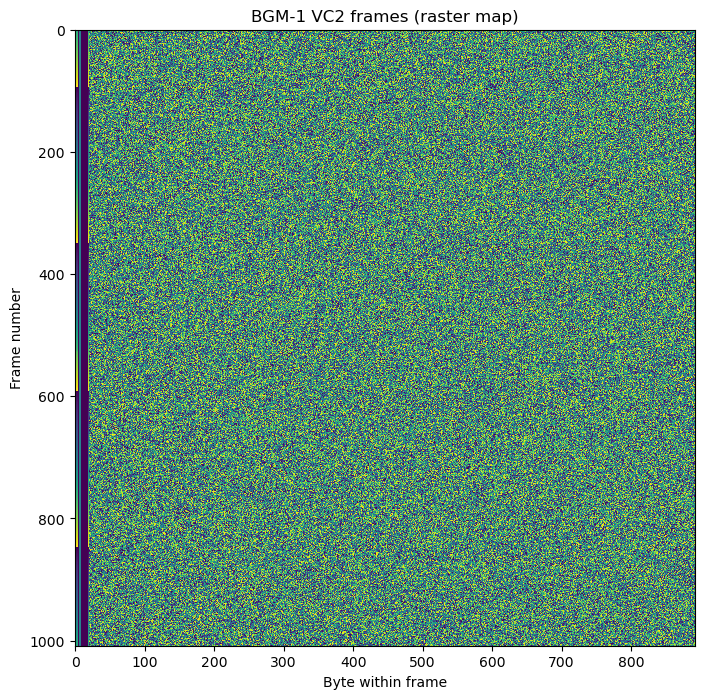

In [19]:
plt.figure(figsize=(8, 8))
plt.imshow(frames_ok[vcid == 2], interpolation='none', aspect='auto')
plt.title('BGM-1 VC2 frames (raster map)')
plt.xlabel('Byte within frame')
plt.ylabel('Frame number');

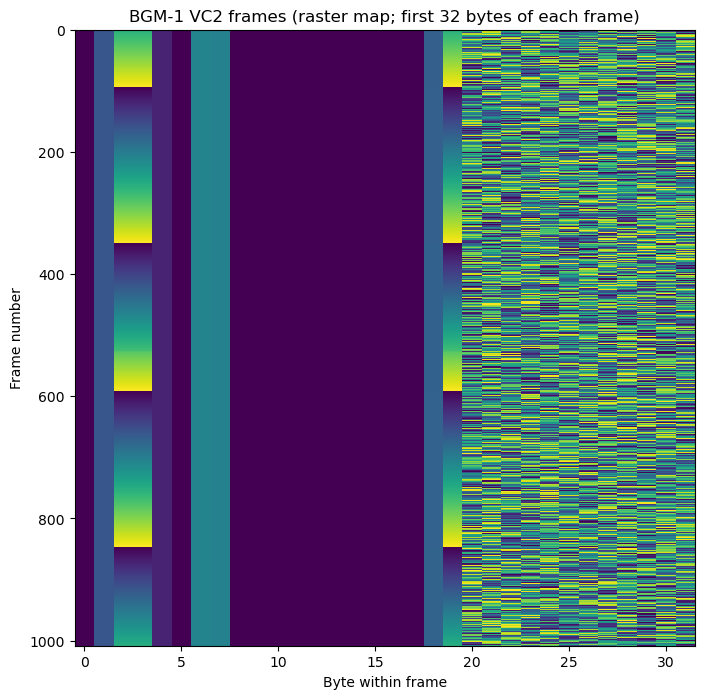

In [20]:
plt.figure(figsize=(8, 8))
plt.imshow(frames_ok[vcid == 2, :32], interpolation='none', aspect='auto')
plt.title('BGM-1 VC2 frames (raster map; first 32 bytes of each frame)')
plt.xlabel('Byte within frame')
plt.ylabel('Frame number');

In [21]:
np.all((frames_ok[vcid == 2] == frames_ok[vcid == 2][0])[:, 6:18])

np.True_

In [22]:
sequence_number = frames_ok[vcid == 2, 18:20].view('>u2').ravel()
np.unique(sequence_number - vcfc_unwrap)

array([19712], dtype=int32)

In [23]:
frames_ok[vcid == 2][0][6:18]

array([115, 112,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
      dtype=uint8)

In [24]:
hex(115), hex(112)

('0x73', '0x70')